## Overview

In this tutorial, you will be introduced to build a simple linear regression model to predict flowers type. We will be covering the following topics:

1. Intrduction to the dataset
2. How to load dataset using Pandas
3. How to split the dataset into training and validation
4. How to train the model in a couple lines of code
5. Plot the dataset

In this tutorial, we are going to use **Logistic Regression** for training our model. As a beginner tutorial, we are not going to cover much details of how logistic regression works. Feel free to read more information about it here: [ https://en.wikipedia.org/wiki/Logistic_regression ]. 

## Introduction to the iris dataset 

The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant

The dataset has four features:
* sepal_length
* sepal_width
* petal_length
* petal_width

Each plant has been measured on those 4 features and the species is recorded.
The question is, if you see a new plant in the field, could you make a prediction of its species based on these meassurements?

The data is saved in a .csv file.




<img src="resources/three-kinds.png" width="700">

<img src="resources/Iris-image.png" width="500">

<img src="resources/raw-data.png" width="400">

## Load dataset using Pandas

### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('iris').getOrCreate()
# PySpark dataframe
df = spark.read.csv('iris.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [4]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
sepal_length,5.1,4.9,4.7,4.6,5
sepal_width,3.5,3,3.2,3.1,3.6
petal_length,1.4,1.4,1.3,1.5,1.4
petal_width,0.2,0.2,0.2,0.2,0.2
species,setosa,setosa,setosa,setosa,setosa


In [5]:
# check how many samples per label
df.groupby('species').count().toPandas()

,species,count
0,virginica,50
1,versicolor,50
2,setosa,50


In [6]:
# summary statistics

numeric_features = [t[0] for t in df.dtypes]
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
sepal_length,150,5.843333333333335,0.8280661279778637,4.3,7.9
sepal_width,150,3.0540000000000007,0.43359431136217375,2.0,4.4
petal_length,150,3.7586666666666693,1.764420419952262,1.0,6.9
petal_width,150,1.1986666666666672,0.7631607417008414,0.1,2.5
species,150,None,None,setosa,virginica


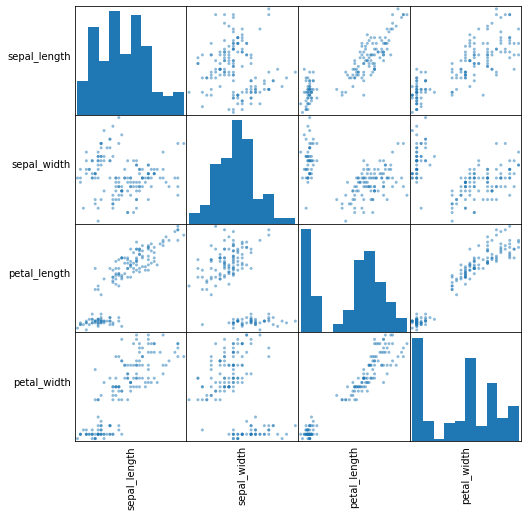

In [7]:
# look into this correlation
# perhaps, find other ways to understand data

numeric_data = df.select(numeric_features[:-1]).toPandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

By default, **head( )** method returns the top 5 rows of dataset

In [8]:
df.head() # If you want to see more of data, say 20 lines, simply use iris.head(20)

Row(sepal_length=5.1, sepal_width=3.5, petal_length=1.4, petal_width=0.2, species='setosa')

**info( )** method lists the data type of each columns, number of non-missing values, and memory usage.

In [9]:
df.toPandas().info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [20]:
df.toPandas().isnull().sum()
#iris.dropna() will remove rows with null values

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [21]:
#Return unique values of Series 'species'
categories = df.toPandas()['species'].unique()
print(categories)

['setosa' 'versicolor' 'virginica']


In [12]:
df.toPandas().describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Split dataset into training set and validation set

In [13]:
X = df.toPandas().iloc[:, 0:4] #all the rows, and column 0 to column 3
y = df.toPandas().iloc[:, 4]#all the row, and column 4

In [14]:
X.info() # only works for DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


### Check data type

In [15]:
print("X's type: " + str(type(X)))
print("Y's type: " + str(type(y)))

X's type: <class 'pandas.core.frame.DataFrame'>
Y's type: <class 'pandas.core.series.Series'>


In [16]:
train, test = df.randomSplit([0.8, 0.2], seed=1)
# test_size should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
# random_state: random seed

In [18]:
train.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  124 non-null    float64
 1   sepal_width   124 non-null    float64
 2   petal_length  124 non-null    float64
 3   petal_width   124 non-null    float64
 4   species       124 non-null    object 
dtypes: float64(4), object(1)
memory usage: 5.0+ KB


In [25]:
print("X_train's shape " + str(train.count()))
print("y_train's shape " + str(test.count()))

X_train's shape 124
y_train's shape 26


In [33]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ["species"]
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

numericCols = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [34]:
stages

[StringIndexer_3a483ae57b70,
 OneHotEncoder_11081b19fb93,
 VectorAssembler_9368487768f1]

In [36]:
cols = df.columns

In [37]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

IllegalArgumentException: requirement failed: Output column speciesIndex already exists.

## Train the model

In [27]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'species', maxIter=10)
lrModel = lr.fit(train)

y_pred = lr.predict(X_test) #Predict class labels for samples in X_test.
print(metrics.accuracy_score(y_test, y_pred))

IllegalArgumentException: features does not exist. Available: sepal_length, sepal_width, petal_length, petal_width, species

<img src="resources/logisticR.png" width="500">

In [14]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(logreg.classes_)

[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
['setosa' 'versicolor' 'virginica']


## Plot the data

In [15]:
# import matplotlib
import matplotlib.pyplot as plt

# seperate each category
setosa = iris[iris["species"]=="setosa"]
versicolor = iris[iris["species"]=="versicolor"]
verginica = iris[iris["species"]=="virginica"]

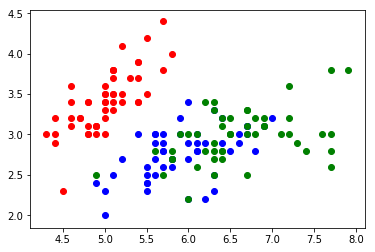

In [16]:
plt.scatter(setosa.values[:, 0], setosa.values[:, 1],c="red" )
plt.scatter(versicolor.values[:, 0], versicolor.values[:, 1], c="blue")
plt.scatter(verginica.values[:,0], verginica.values[:,1], c="green")
plt.show()

## Reference

* https://archive.ics.uci.edu/ml/datasets/iris<br>
* "Python Data Analytics: With Pandas, NumPy, and Matplotlib" 2ed by Fabio Nelli.
* https://www.datacamp.com/community/tutorials/logistic-regression-R